# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
from sparse_field_lib import load_data

In [3]:
import matplotlib.pyplot as plt
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

from astropy.table import Table

In [4]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import plotly.express as px
import plotly.graph_objects as go

In [5]:
# where is the sdss data? 
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [6]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

5


## Utility

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def imshow_cbar(fig, ax, image, vmin=None, vmax=None, s=20): 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(image, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=s)

# Load data

In [8]:
sdss_data = sdss.SloanDigitalSkySurvey(
    sdss_dir=sdss_dir,
    run=94,
    camcol=1,
    fields=(12,),
    bands=range(5),
    overwrite_cache=True,
    overwrite_fits_cache=True,
)

In [9]:
frame, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)
frame_fits = Table(sdss_data[0]['po_fits'])
print("# objects detected by photo on frame: ", len(frame_fits))
print("# objects detected by photo on coadd: ", len(fits_file['ra'][:]))
frame = frame[0].numpy()
print(frame.shape)

# objects detected by photo on frame:  999
# objects detected by photo on coadd:  901
(1489, 2048)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [10]:
wcs = wcs_list[0]
pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)
pt_frame, pr_frame = wcs.all_world2pix(frame_fits['RA'].reshape(-1), frame_fits['DEC'].reshape(-1), 0)

# remove all locations that are not inside the image. 
keep = (pt > 0) & (pt < frame.shape[1]-1) & (pr > 0) & (pr < frame.shape[0]-1)
pt = pt[keep]
pr = pr[keep]

keep_frame = (pt_frame > 1) & (pt_frame < frame.shape[1]-1) & (pr_frame > 1) & (pr_frame < frame.shape[0]-1)
pt_frame = pt_frame[keep_frame]
pr_frame = pr_frame[keep_frame]

# Visualize Frame

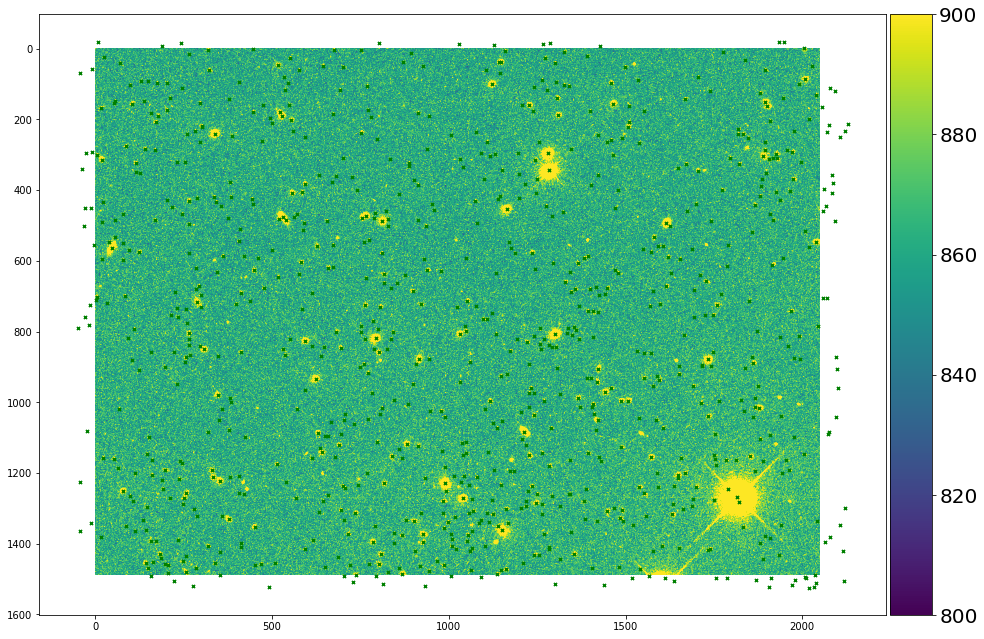

In [12]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
imshow_cbar(fig, ax, frame, vmin=800, vmax=900)
ax.scatter(x=pt, y=pr, c='r', marker='x', s=10)

# Run BLISS on 300x300 chunk

## prepare model

In [13]:
# prepare BLISS model 
checkpoint_file = '/home/imendoza/bliss/models/sleep_sdss_measure.ckpt'
sleep_net= sleep.SleepPhase.load_from_checkpoint(checkpoint_file).to(device)
image_encoder = sleep_net.image_encoder
galaxy_encoder = sleep_net.galaxy_encoder

# important to turn on .eval() mode!
sleep_net = sleep_net.eval()
sleep_net.galaxy_encoder.eval()
image_encoder = image_encoder.eval()

## choose chunk

In [14]:
lims = [
    ((450, 750), (350, 650)), #fiducial
    ((1250, 1550), (680, 980)), #random
    ((200, 500), (1050, 1350)), #blends
    ((1100, 1400), ((950, 1250))), #another large galaxy
    ((1000, 1300), (50, 350)), # very faint, small sources. 
    ((900, 1200), (1100, 1400)), # random

]    
choice = -1
xlim, ylim = lims[choice]

In [15]:
assert xlim[1] - xlim[0] == 300 
assert ylim[1] - ylim[0] == 300

chunk = frame[ylim[0]:ylim[1], xlim[0]:xlim[1]]

# restrict to 300x300 chunk 
keep = (pt > xlim[0]) & (pt < xlim[1]) & (pr < ylim[1]) & (pr > ylim[0])
keep_frame = (pt_frame > xlim[0]) & (pt_frame < xlim[1]) & (pr_frame < ylim[1]) & (pr_frame > ylim[0])

# obtain star and galaxy bools for each location.
is_star = fits_file['probpsf'][:].astype(bool)
is_star_frame = (frame_fits['OBJC_TYPE'][:]==6).astype(bool)
galaxy_bool = (~is_star) & keep
star_bool = is_star & keep
galaxy_bool_frame = (~is_star_frame) & keep_frame
star_bool_frame = (is_star_frame) & keep_frame

#account for bias
_pt = pt - xlim[0]
_pr = pr - ylim[0]

_pt_frame = pt_frame - xlim[0]
_pr_frame = pr_frame - ylim[0]

# move image to device
slen = 300
chunk = torch.from_numpy(chunk.reshape(1, 1, *chunk.shape)[:, :, :slen, :slen]).to(device)

# for plotting
_chunk = chunk.reshape(300,300).cpu().numpy()
print(chunk.shape, _chunk.shape)

torch.Size([1, 1, 300, 300]) (300, 300)


## get estimate from chunk

In [16]:
with torch.no_grad():

    tile_est = sleep_net.tile_images_map_estimate(chunk)
    
    # plot image from tile est.
    recon_image, _ = sleep_net.image_decoder.render_images(
        tile_est["n_sources"],
        tile_est["locs"],
        tile_est["galaxy_bool"],
        tile_est["galaxy_params"],
        tile_est["fluxes"],
        add_noise=False,
    )
    
    _slen = chunk.shape[-1] - image_encoder.border_padding*2
    est_params = encoder.get_full_params(tile_est, _slen)

## plot detections

In [17]:
import plotly.express as px
import plotly.graph_objects as go
p_box = widgets.Dropdown(options=[1e-4, 5e-4, 1e-3,5e-3,1e-2,5e-2, 0.1, 0.3], description="p1")
@interact(p=p_box)
def plot_chunk(p):
    vmin = np.quantile(_chunk.flatten(), p)
    vmax = np.quantile(_chunk.flatten(), 1.-p)
    fig = px.imshow(_chunk, zmin=vmin, zmax=vmax)

    # scatter objects.
    scatter_galaxies_frame = go.Scatter(name='frame_galaxy', x=_pt_frame[galaxy_bool_frame], y=_pr_frame[galaxy_bool_frame], mode='markers', marker=dict(color='green', size=8, symbol='x'))
    scatter_stars_frame = go.Scatter(name='frame_star', x=_pt_frame[star_bool_frame], y=_pr_frame[star_bool_frame], mode='markers', marker=dict(color='purple', size=8, symbol='x'))

    scatter_galaxies_true = go.Scatter(name='true_galaxy', x=_pt[galaxy_bool], y=_pr[galaxy_bool], mode='markers', marker=dict(color='red', size=8, symbol='x'))
    scatter_stars_true = go.Scatter(name='true_star', x=_pt[star_bool], y=_pr[star_bool], mode='markers', marker=dict(color='orange', size=8, symbol='x'))

    _locs = est_params['locs']*_slen + image_encoder.border_padding - 0.5
    _locs = _locs.detach().cpu().numpy()[0]
    _galaxy_bool = est_params['galaxy_bool'].bool().detach().cpu().numpy()[0, :, 0]
    _prob_galaxy = est_params['prob_galaxy'].float().detach().cpu().numpy()[0, :, 0]
    _prob_n_sources = est_params['prob_n_sources'].float().detach().cpu().numpy()[0, :, 1]


    scatter_galaxies_est = go.Scatter(name='est_galaxy', x=_locs[:, 1][_galaxy_bool], y=_locs[:, 0][_galaxy_bool], 
                                      mode='markers', marker=dict(color='blue', size=8, symbol='cross'),
                                      hovertext=[f'prob_galaxy:{x:.2f}; prob_one_source: {y:.2f}' for (x,y) 
                                                 in zip(_prob_galaxy[_galaxy_bool], _prob_n_sources[_galaxy_bool])]
                                     )
    scatter_stars_est = go.Scatter(name='est_star', x=_locs[:, 1][~_galaxy_bool], y=_locs[:, 0][~_galaxy_bool], 
                                   mode='markers', marker=dict(color='cyan', size=8, symbol='cross'),
                                  hovertext=[f'prob_galaxy:{x:.2f}; prob_one_source: {y:.2f}' for (x,y) in 
                                             zip(_prob_galaxy[~_galaxy_bool], _prob_n_sources[~_galaxy_bool])]
                                  )

    # add traces
    fig.update_layout(width=800, height=800)
    fig.add_trace(scatter_galaxies_true)
    fig.add_trace(scatter_stars_true)
    fig.add_trace(scatter_galaxies_est)
    fig.add_trace(scatter_stars_est)
    fig.add_trace(scatter_galaxies_frame)
    fig.add_trace(scatter_stars_frame)
    fig.update_layout(legend=dict(orientation="h", y=1.02))
    
    # add border padding
    fig.add_shape(type="line", x0=24, x1=24, y0=0, y1=300, line=dict(color='white', width=3))
    fig.add_shape(type="line", x0=276, x1=276, y0=0, y1=300, line=dict(color='white', width=3))
    fig.add_shape(type="line", x0=0, x1=300, y0=24, y1=24, line=dict(color='white', width=3))
    fig.add_shape(type="line", x0=0, x1=300, y0=276, y1=276, line=dict(color='white', width=3))


    fig.show()


interactive(children=(Dropdown(description='p1', options=(0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3),…

In [18]:
%matplotlib inline
p1_box = widgets.Dropdown(options=[1e-4, 5e-4, 1e-3,5e-3,1e-2,5e-2, 0.1, 0.3], description="p1")
p2_box = widgets.Dropdown(options=[1e-4, 5e-4, 1e-3,5e-3,1e-2,5e-2, 0.1, 0.3], description="p2")
@interact(p1=p1_box, p2=p2_box)
def plot_residuals(p1, p2):
    # plot both images side by side.
    fig, axes = plt.subplots(1, 3, figsize=(35,13))
    _recon_image = recon_image.detach().cpu().numpy()[0, 0]


    # crop the border padding
    bpad = image_encoder.border_padding
    print(bpad)
    __chunk = _chunk[bpad:slen-bpad, bpad:slen-bpad]
    __recon_image = _recon_image[bpad:slen-bpad, bpad:slen-bpad]
    residual = (__chunk - __recon_image)/np.sqrt(__recon_image)

    print(__chunk.shape)
    
    ax1, ax2, ax3 = axes


    combined = np.hstack([__chunk.flatten(), __recon_image.flatten()])
    vmin1 = np.quantile(combined, p1)
    vmax1 = np.quantile(combined, 1. - p1)
    vmin2 = np.quantile(residual.flatten(), p2)
    vmax2 = np.quantile(residual.flatten(), 1. - p2)

    # plot the chunk and reconstruction image side by side.
    im1 = imshow_cbar(fig, ax1, __chunk, vmin=vmin1, vmax=vmax1)
    im2 = imshow_cbar(fig, ax2, __recon_image, vmin=vmin1, vmax=vmax1)
    im3 = imshow_cbar(fig, ax3, residual, vmin=vmin2, vmax=vmax2)

    # true image and true locations
    __pt = _pt - bpad
    __pr = _pr - bpad
    keep = (__pt > 0) & (__pr > 0) & (__pt < 252) & (__pr < 252)
    galaxy_bool_ = galaxy_bool & keep
    star_bool_ = star_bool & keep
    ax1.scatter(__pt[galaxy_bool_], __pr[galaxy_bool_], marker='x', color='r', s=40)
    ax1.scatter(__pt[star_bool_], __pr[star_bool_], marker='+', color='b', s=50)
    
    # # frame
    # ax1.scatter(_pt_frame[galaxy_bool_frame], _pr_frame[galaxy_bool_frame], marker='x', color='r', s=40)
    # ax1.scatter(_pt_frame[star_bool_frame], _pr_frame[star_bool_frame], marker='+', color='b', s=50)


    # overlay the map estimate params on the full image
    _locs = est_params['locs']*_slen - 0.5
    _locs = _locs.detach().cpu().numpy()[0]
    _galaxy_bool = est_params['galaxy_bool'].bool().detach().cpu().numpy()[0, :, 0]
    _prob_galaxy = est_params['prob_galaxy'].float().detach().cpu().numpy()[0, :, 0]
    _prob_n_sources = est_params['prob_n_sources'].float().detach().cpu().numpy()[0, :, 1]
    
    
    ax2.scatter(_locs[:, 1][_galaxy_bool], _locs[:, 0][_galaxy_bool], marker='x', color='r', s=40)
    ax2.scatter(_locs[:, 1][~_galaxy_bool], _locs[:, 0][~_galaxy_bool], marker='+', color='b', s=50)

    # annotate with probabilities for sharing
    for prob, (yi, xi) in zip(_prob_galaxy[_galaxy_bool], _locs[_galaxy_bool]):
        ax2.annotate(f"{prob:.2f}", (xi, yi), color='r', fontsize=14)

    for prob, (yi, xi) in zip(_prob_galaxy[~_galaxy_bool], _locs[~_galaxy_bool]):
        ax2.annotate(f"{prob:.2f}", (xi, yi), color='b', fontsize=14)


    plt.tight_layout()

    print('red = galaxy')
    print('blue = star')
    plt.show()

interactive(children=(Dropdown(description='p1', options=(0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3),…